# Testing bias metrics and mitigation algorithms on a Synthetic dataset

The goal of this analysis is to make a comparison of different bias mitigation methods for classification problems on different types of dataset and to see how these methods impact on different fairness metrics and on the accuracy of the classifier. The datasets on which we will test the fairness algorithms are:

1. Unbias dataset
2. Bias unbalanced dataset
3. Bias balanced dataset

In [26]:
# import libraries
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utility import *
sns.set_theme()

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the target variable at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the target variable $y$ are changed s.t. the mean of the $y$ distribution is the mean between the mean of $y$ distribution for the privileged and unprivileged groups. 
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

## Dataset creation

Here we will create a binary labeled dataset with 10.000 samples and 11 features of which 4 are informative features and one will act as sensitive attribute:

In [27]:
n_samples = 10000
n_features = 10
n_informative = 4
n_sensitive = 2

In [28]:
data = pd.read_csv('synthetic/synthetic.csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,10,s
0,1.117819,2.978286,0.446270,1.462078,-0.603682,-1.010214,-0.850477,-0.534090,2.619979,2.847635,1.0,0
1,-1.241114,0.966580,2.522553,2.197615,-2.049246,-2.272453,-0.912986,-1.074081,0.156897,-0.893949,0.0,0
2,1.499456,3.462662,-1.581721,-0.717028,0.706507,0.067985,1.081010,-1.360287,2.342430,2.600052,1.0,1
3,1.119152,-1.030551,2.154243,-1.041053,0.374413,-1.707872,1.508272,0.426323,-1.545117,-1.741156,0.0,0
4,0.951065,3.900728,0.127303,-0.075893,0.416828,-1.444766,-0.093549,-2.440322,2.097760,1.317815,0.0,1


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


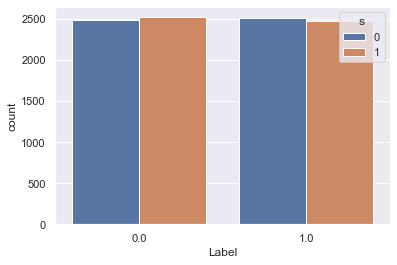

In [29]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

The dataset seems to be fair with respect to the sensitive attribute

In [30]:
unprivileged_group = [{'s': 0}]
privileged_group = [{'s': 1}]

# Unbias dataset

Here we will apply the metrics and the algorithms defined above on the unbias version of the dataset and compare how these bias mitigation algorithms change the different metrics.

## Dataset fairness metrics 

Let's compute the dataset fairness metrics defined above on the syntetic dataset to check that it is really unbias

In [31]:
bin_data = BinaryLabelDataset(df=data, label_names=['10'], protected_attribute_names=['s'])
metrics = compute_dataset_fairness_metrics(bin_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0161
Statistical Parity = 0.0080


The dataset is not bias.

## Classification bias metrics

Here we train and test a _Logistic Regression_ classifier:

Balanced accuracy: 0.7633
Statistical parity difference: 0.0194
Disparate impact: 1.0399
Average odds difference: 0.0160
Equal opportunity difference: 0.0198
Theil index: 0.1480


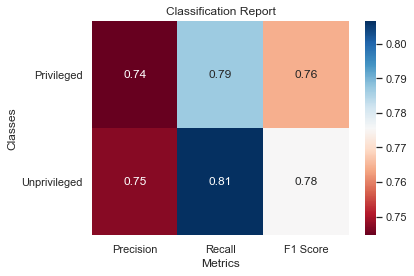

In [32]:
class_metrics = classify(
    make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced', solver='liblinear')),
    bin_data, privileged_group, unprivileged_group)

From the values of the metrics we can see that the classifier is fair and quite accurate. Let's now test the same metrics on a bias dataset.

## Reweighing

Here we apply the _Reweighing_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [33]:
rw_unbias_data = bin_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_unbias_data = rw.fit_transform(rw_unbias_data)

In [34]:
np.unique(rw_unbias_data.instance_weights)

array([0.99205719, 0.99206979, 1.00805802, 1.00807103])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


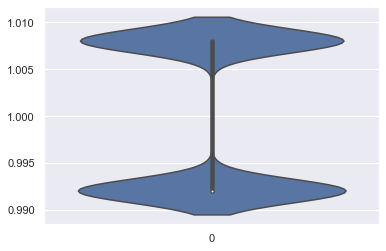

In [35]:
sns.violinplot(data=rw_unbias_data.instance_weights)
plt.show()

### Dataset metrics

In [36]:
metrics = compute_dataset_fairness_metrics(rw_unbias_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

Balanced accuracy: 0.7633
Statistical parity difference: 0.0055
Disparate impact: 1.0109
Average odds difference: 0.0058
Equal opportunity difference: 0.0083
Theil index: 0.1473


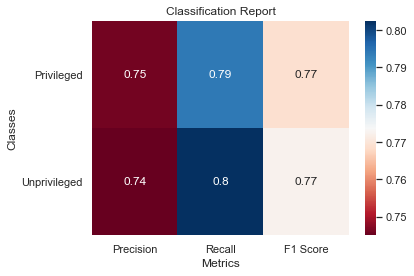

In [37]:
rw_un_metrics = classify(
    make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_unbias_data, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


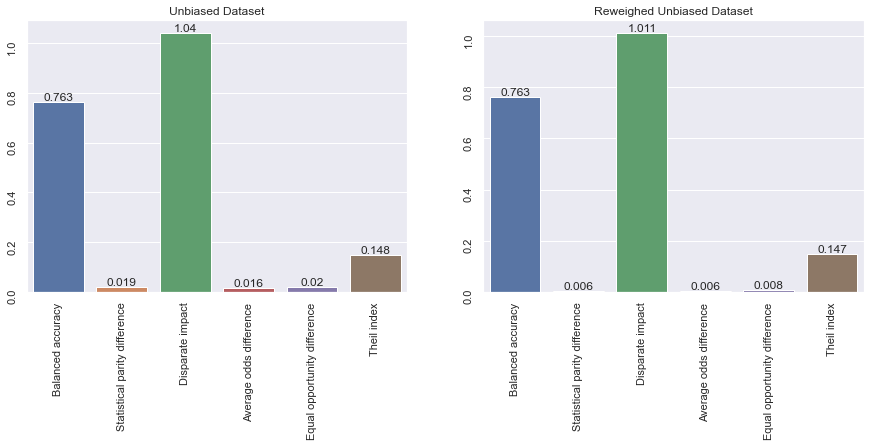

In [38]:
plot_metrics_comparison(class_metrics, rw_un_metrics, "Unbiased Dataset", "Reweighed Unbiased Dataset")
plt.show()

## Disparate Impact Remover

Here we apply the _Disparate Impact Remover_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [39]:
dir_unb_data = bin_data.copy()
scaler = MinMaxScaler(copy=False)
dir_unb_data.features = scaler.fit_transform(dir_unb_data.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


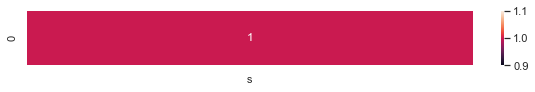

In [40]:
plot_correlation(dir_unb_data, 's')
plt.show()

In [41]:
di = DisparateImpactRemover(sensitive_attribute='s')
dir_unb_data = di.fit_transform(dir_unb_data)

### Dataset metrics

In [42]:
metrics = compute_dataset_fairness_metrics(dir_unb_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0161
Statistical Parity = 0.0080


### Classification metrics

Balanced accuracy: 0.7638
Statistical parity difference: 0.0056
Disparate impact: 1.0116
Average odds difference: 0.0016
Equal opportunity difference: 0.0027
Theil index: 0.1474


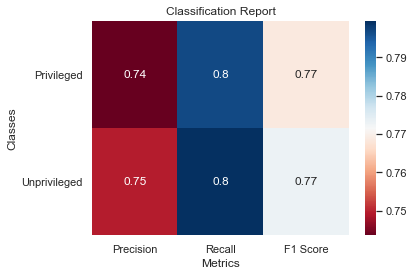

In [43]:
dir_fair_metrics = classify(
    make_pipeline(StandardScaler(),
                  LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_unb_data, privileged_group, unprivileged_group, sensitive_attributes=['s'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


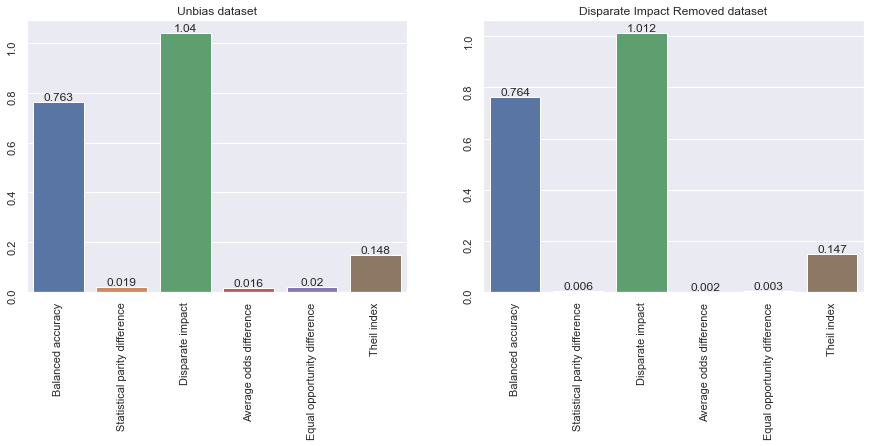

In [44]:
plot_metrics_comparison(class_metrics, dir_fair_metrics, "Unbias dataset", "Disparate Impact Removed dataset")
plt.show()

## Modified Reweighing (Sampling)

Original dataset size: (10000,12)
Sampled dataset size: (10000,12)


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


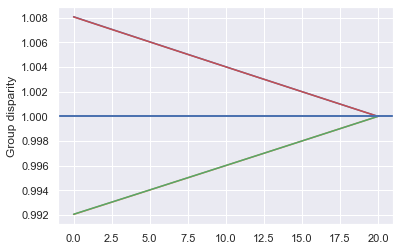

In [45]:
unb_sample_ds = data.copy()
unb_sample_ds = sample_dataset(
    unb_sample_ds,
    [unb_sample_ds['s']==1, unb_sample_ds['s']==0],
    unb_sample_ds['10']==1,
    unb_sample_ds['10']==0,
    ['s'], '10')
plt.show()

### Dataset Metrics

In [46]:
metrics = compute_dataset_fairness_metrics(unb_sample_ds, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification Metrics

Balanced accuracy: 0.7636
Statistical parity difference: 0.0035
Disparate impact: 1.0079
Average odds difference: 0.0028
Equal opportunity difference: 0.0050
Theil index: 0.1476


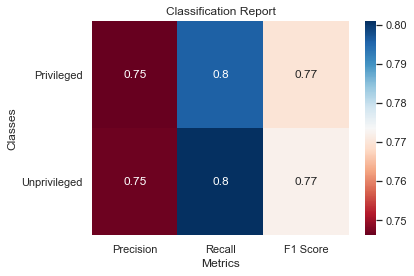

In [47]:
unb_sample_metrics = classify(
    make_pipeline(StandardScaler(),
                  LogisticRegression(class_weight='balanced', solver='liblinear')), 
                  unb_sample_ds, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


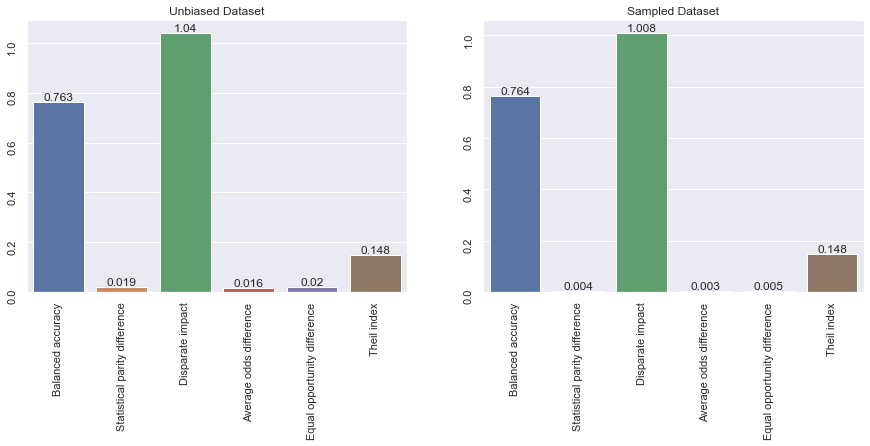

In [48]:
plot_metrics_comparison(class_metrics, unb_sample_metrics, 'Unbiased Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In the following we compare the performances of _Reweighing_ and _Disparate Impact Remover_ on the unbias dataset. 

In [49]:
un_merged_metrics = merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Sampled Dataset': unb_sample_metrics,
    'Disparate Impact Removed': dir_fair_metrics
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Disparate Impact Removed,0.0016,0.7638,1.0116,0.0027,0.0056,0.1474
Reweighed,0.0058,0.7633,1.0109,0.0083,0.0055,0.1473
Sampled Dataset,0.0028,0.7636,1.0079,0.0050,0.0035,0.1476
Unbias Data,0.0160,0.7633,1.0399,0.0198,0.0194,0.1480


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


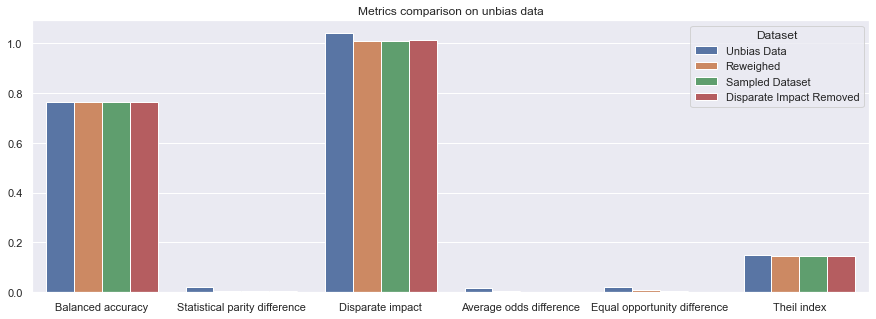

In [50]:
plot_syntesis(un_merged_metrics, 'Metrics comparison on unbias data')
plt.show()

# Unbalanced Bias dataset

Let's change the previous dataset adding a bias on the sensitive attribute `s` with value 0 and keeping the instances with `s=1` invariate:

In [51]:
bias_data = data.copy()
bias_data.loc[(bias_data['s'] == 0) & (bias_data.index < int(n_samples/2)) , '10'] = 0.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


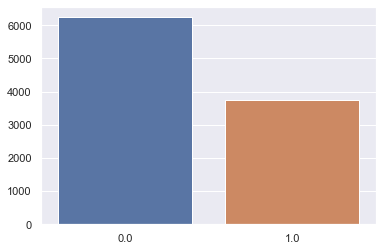

In [52]:
sns.barplot(x=bias_data['10'].value_counts().index, y=bias_data['10'].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


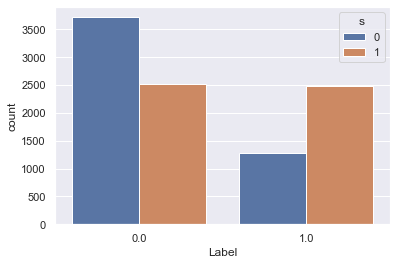

In [53]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

## Dataset fairness metrics

Let's compute the dataset fairness metrics on this new dataset:

In [54]:
bias_data_bin = BinaryLabelDataset(df = bias_data, label_names=['10'], protected_attribute_names=['s'])
bias_metrics = compute_dataset_fairness_metrics(bias_data_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.5174
Statistical Parity = -0.2392


## Classification bias metrics

Balanced accuracy: 0.7262
Statistical parity difference: -0.3988
Disparate impact: 0.3971
Average odds difference: -0.3549
Equal opportunity difference: -0.5165
Theil index: 0.1500


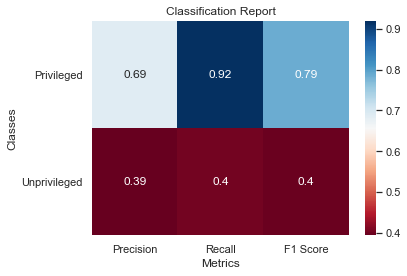

In [55]:
bias_class_metrics = classify(
    make_pipeline(StandardScaler(), 
                  LogisticRegression(class_weight='balanced', solver='liblinear')), 
                  bias_data_bin, privileged_group, unprivileged_group)

##  Reweighing

In [56]:
rw_data = bias_data_bin.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
rw_data = rw.fit_transform(rw_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


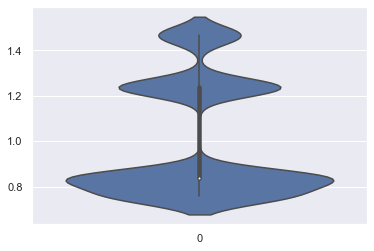

In [57]:
sns.violinplot(data=rw_data.instance_weights)
plt.show()

### Dataset metrics

In [58]:
rw_metrics = compute_dataset_fairness_metrics(rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = -0.0000


### Classification metrics

Balanced accuracy: 0.7118
Statistical parity difference: 0.0359
Disparate impact: 1.0769
Average odds difference: 0.0107
Equal opportunity difference: -0.0895
Theil index: 0.1437


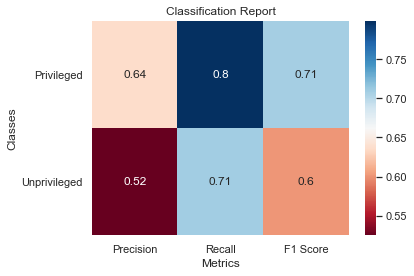

In [59]:
rw_class_metrics = classify(make_pipeline(StandardScaler(), 
                                          LogisticRegression(class_weight='balanced', solver='liblinear')), rw_data, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


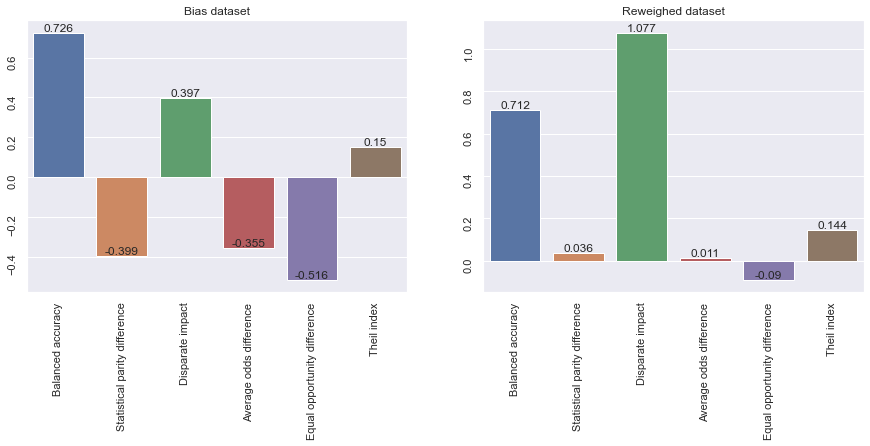

In [60]:
plot_metrics_comparison(bias_class_metrics, rw_class_metrics, "Bias dataset", "Reweighed dataset")
plt.show()

## Disparate Impact Remover

In [61]:
dir_data = bias_data_bin.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


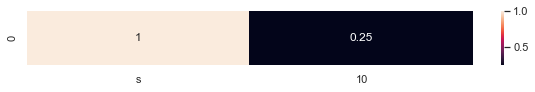

In [62]:
plot_correlation(dir_data, 's')
plt.show()

In [63]:
dr = DisparateImpactRemover(sensitive_attribute='s')
dir_data = dr.fit_transform(dir_data)

### Dataset metrics

In [64]:
dir_metrics = compute_dataset_fairness_metrics(dir_data, unprivileged_group, privileged_group)

Disparate Impact = 0.5174
Statistical Parity = -0.2392


### Classification metrics

Balanced accuracy: 0.7057
Statistical parity difference: 0.0102
Disparate impact: 1.0226
Average odds difference: 0.0927
Equal opportunity difference: 0.0118
Theil index: 0.1502


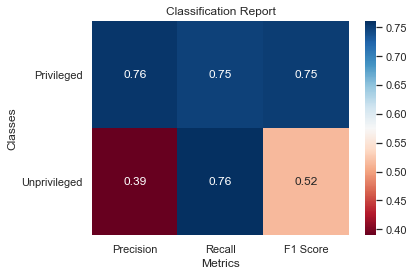

In [65]:
dir_class_metrics = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced',solver='liblinear')), dir_data, privileged_group, unprivileged_group,sensitive_attributes=['s'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


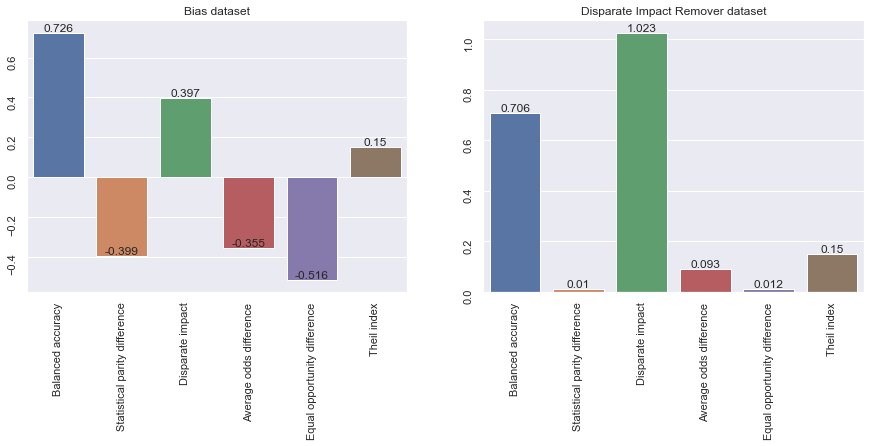

In [66]:
plot_metrics_comparison(bias_class_metrics, dir_class_metrics, "Bias dataset", "Disparate Impact Remover dataset")
plt.show()

## Modified Reweighing (Sampling)

Original dataset size: (10000,12)
Sampled dataset size: (10000,12)


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


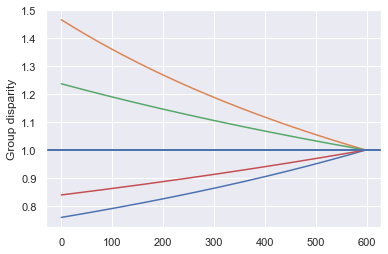

In [67]:
sample_bias_data = sample_dataset(bias_data.copy(),
 [(bias_data['s']==1), (bias_data['s']==0)], 
 bias_data['10']==1, bias_data['10']==0, ['s'], '10')
plt.show()

In [68]:
metrics = compute_dataset_fairness_metrics(sample_bias_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.7126
Statistical parity difference: 0.0365
Disparate impact: 1.0780
Average odds difference: 0.0121
Equal opportunity difference: -0.0848
Theil index: 0.1481


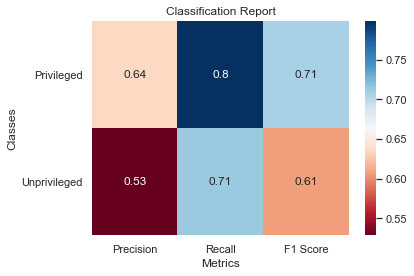

In [69]:
sample_bias_metrics = classify(make_pipeline(StandardScaler(), 
                                             LogisticRegression(class_weight='balanced', solver='liblinear')), 
                               sample_bias_data, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


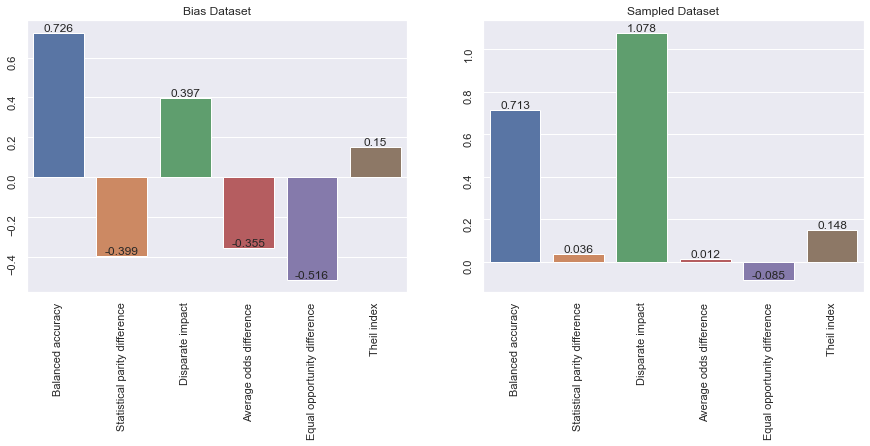

In [70]:
plot_metrics_comparison(bias_class_metrics, sample_bias_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In [71]:
unbal_merged_metrics = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Sampled Dataset': sample_bias_metrics,
    'Disparate Impact Removed': dir_class_metrics
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias unbalanced data,-0.3549,0.7262,0.3971,-0.5165,-0.3988,0.1500
Disparate Impact Removed,0.0927,0.7057,1.0226,0.0118,0.0102,0.1502
Reweighed,0.0107,0.7118,1.0769,-0.0895,0.0359,0.1437
Sampled Dataset,0.0121,0.7126,1.0780,-0.0848,0.0365,0.1481


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


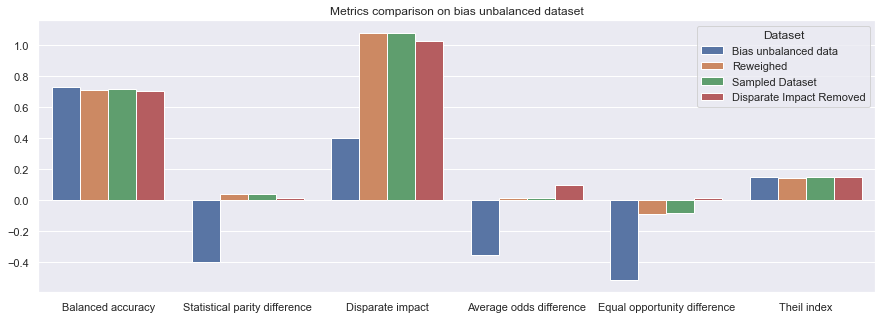

In [72]:
plot_syntesis(unbal_merged_metrics, 'Metrics comparison on bias unbalanced dataset')
plt.show()

# Bias balanced dataset

Let's balance the previous dataset changing the labels of half of the samples with `s=1` to `1.0`

In [73]:
bias_bal_data = bias_data.copy()
bias_bal_data.loc[(bias_data['s'] == 1) & (bias_data.index < int(n_samples/2)) & (bias_data['10']==0.0) , '10'] = 1.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


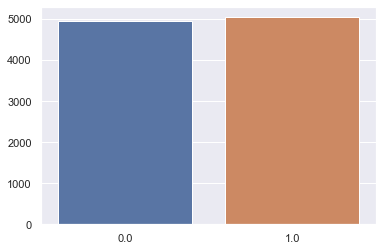

In [74]:
sns.barplot(x=bias_bal_data['10'].value_counts().index, y=bias_bal_data['10'].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


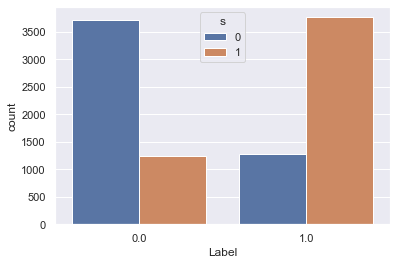

In [75]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_bal_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

In [76]:
bias_bal_bin = BinaryLabelDataset(df=bias_bal_data, label_names=['10'], protected_attribute_names=['s'])

## Dataset metrics

In [77]:
bal_metrics = compute_dataset_fairness_metrics(bias_bal_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.3406
Statistical Parity = -0.4964


## Classification metrics

Balanced accuracy: 0.7418
Statistical parity difference: -0.8868
Disparate impact: 0.0418
Average odds difference: -0.8575
Equal opportunity difference: -0.8924
Theil index: 0.1901


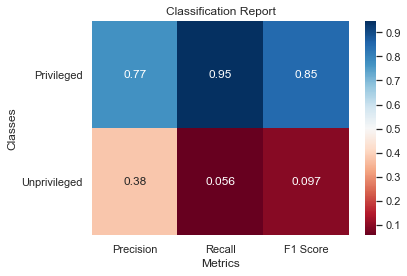

In [78]:
bias_bal_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    bias_bal_bin, privileged_group, unprivileged_group)

## Reweighing

In [79]:
rw_bal = bias_bal_bin.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_bal = rw.fit_transform(rw_bal)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


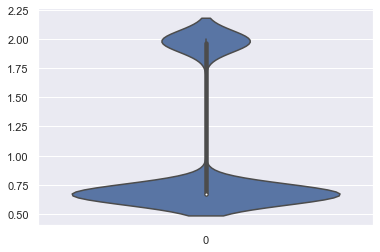

In [80]:
sns.violinplot(data=rw_bal.instance_weights)
plt.show()

### Dataset metrics

In [81]:
rw_metrics = compute_dataset_fairness_metrics(rw_bal, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

Balanced accuracy: 0.6696
Statistical parity difference: 0.0295
Disparate impact: 1.0578
Average odds difference: 0.0307
Equal opportunity difference: 0.0251
Theil index: 0.2143


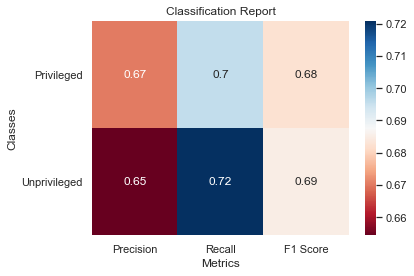

In [82]:
rw_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_bal, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


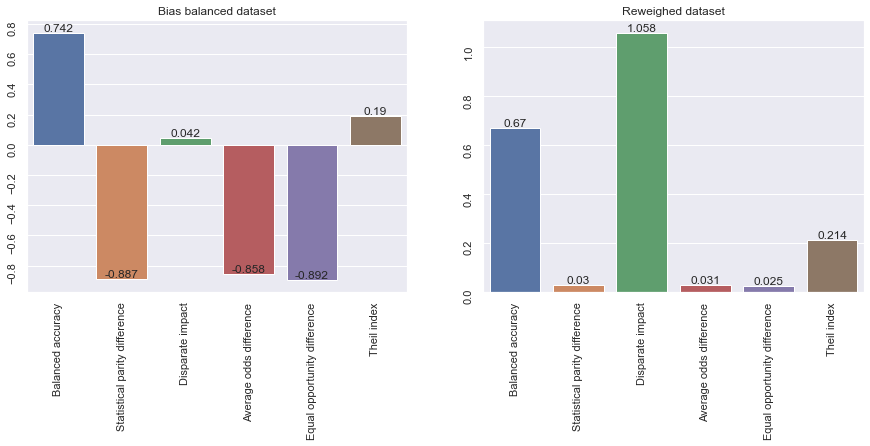

In [83]:
plot_metrics_comparison(bias_bal_metrics, rw_metrics, 'Bias balanced dataset', 'Reweighed dataset')
plt.show()

## Modified Reweighing (Sampling)

Original dataset size: (10000,12)
Sampled dataset size: (10000,12)


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


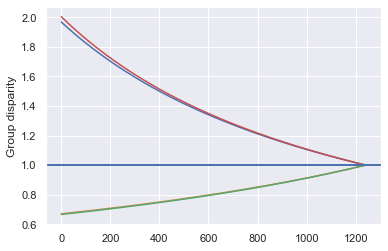

In [84]:
bias_sample_ds = sample_dataset(
    bias_bal_data.copy(),
    [bias_bal_data['s']==0, bias_bal_data['s']==1],
    bias_bal_data['10']==1,
    bias_bal_data['10']==0,
    ['s'], '10')
plt.show()

In [85]:
metrics = compute_dataset_fairness_metrics(bias_sample_ds,unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.6660
Statistical parity difference: 0.0253
Disparate impact: 1.0494
Average odds difference: 0.0250
Equal opportunity difference: 0.0151
Theil index: 0.2133


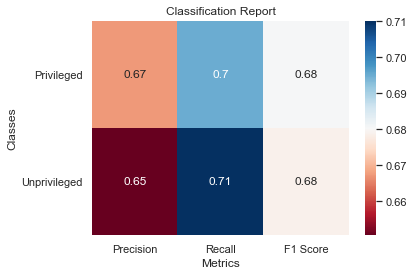

In [86]:
sampling_metrics = classify(make_pipeline(
    StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                            bias_sample_ds, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


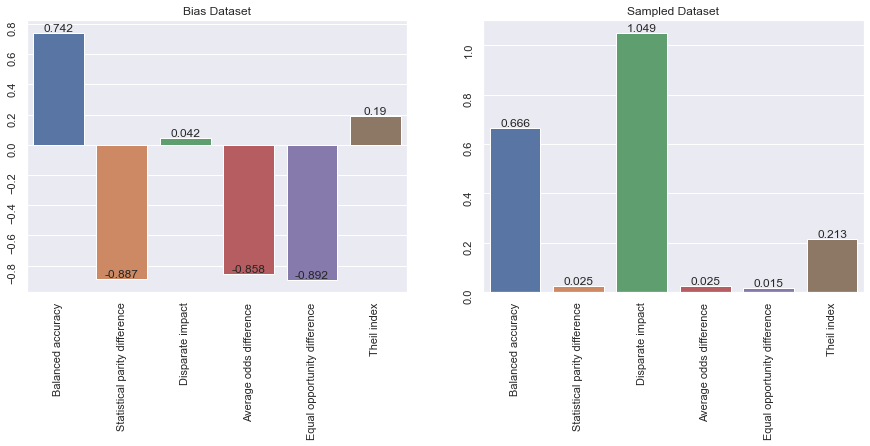

In [87]:
plot_metrics_comparison(bias_bal_metrics, sampling_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Disparate Impact Remover

In [88]:
dir_bal = bias_bal_bin.copy()
scaler = MinMaxScaler()
dir_bal.features = scaler.fit_transform(dir_bal.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


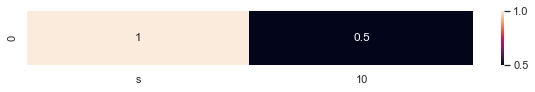

In [89]:
plot_correlation(dir_bal, 's')
plt.show()

In [90]:
dr = DisparateImpactRemover(sensitive_attribute='s')
dir_bal = dr.fit_transform(dir_bal)

### Dataset metrics

In [91]:
dir_metrics = compute_dataset_fairness_metrics(dir_bal, unprivileged_group, privileged_group)

Disparate Impact = 0.3406
Statistical Parity = -0.4964


### Classification metrics

Balanced accuracy: 0.6309
Statistical parity difference: 0.0074
Disparate impact: 1.0160
Average odds difference: 0.1840
Equal opportunity difference: 0.1861
Theil index: 0.2320


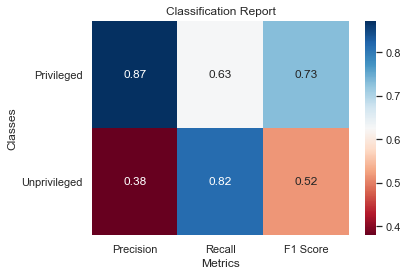

In [92]:
dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                     dir_bal, privileged_group, unprivileged_group, sensitive_attributes=['s'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


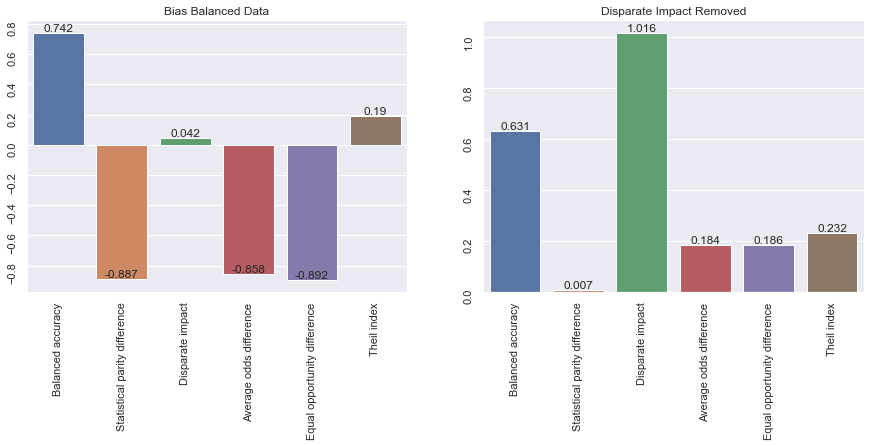

In [93]:
plot_metrics_comparison(bias_bal_metrics, dir_score, 'Bias Balanced Data', 'Disparate Impact Removed')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In [94]:
bal_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Sampled Dataset': sampling_metrics,
    'Disparate Impact Removed': dir_score
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Balanced Data,-0.8575,0.7418,0.0418,-0.8924,-0.8868,0.1901
Disparate Impact Removed,0.1840,0.6309,1.0160,0.1861,0.0074,0.2320
Reweighed,0.0307,0.6696,1.0578,0.0251,0.0295,0.2143
Sampled Dataset,0.0250,0.6660,1.0494,0.0151,0.0253,0.2133


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


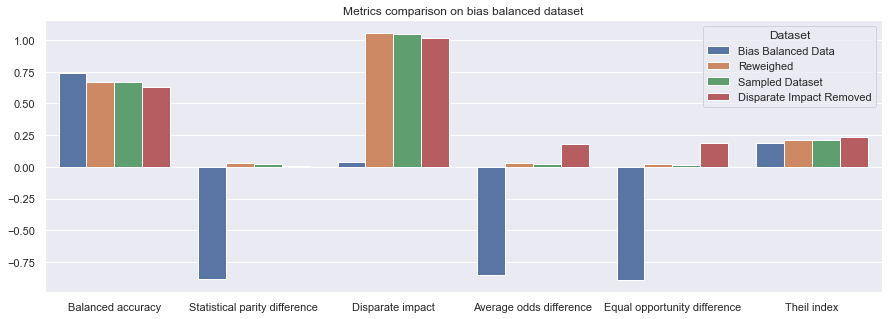

In [95]:
plot_syntesis(bal_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()

# Comparison of the three datasets

Here we compare the metrics for the three versions of the dataset and the methods applied:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


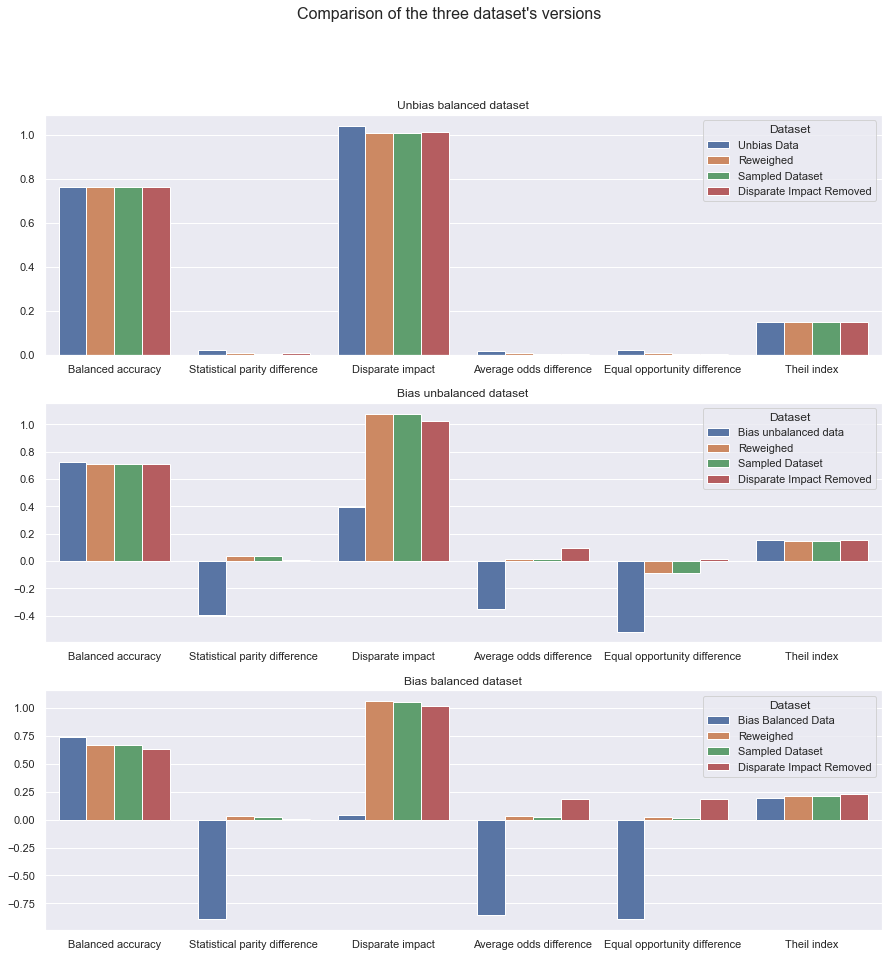

In [96]:
fig, axes = plt.subplots(3,1,figsize=(15,15))
sns.barplot(data=un_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[0],)
sns.barplot(data=unbal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[1])
sns.barplot(data=bal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[2])
for ax in axes:
    ax.set(xlabel='', ylabel='')
axes[0].set_title('Unbias balanced dataset')
axes[1].set_title('Bias unbalanced dataset')
axes[2].set_title('Bias balanced dataset')
fig.suptitle("Comparison of the three dataset's versions", fontsize=16)
plt.show()

# Combine Reweighing and DIR

As can be seen from the charts above both RW and DIR performs well in mitigating the unfairness of the classifier. However both have some lacks:

1. Reweighing requires that a classifier takes account of instance weights, but not all the classifier models do so
2. Disparate Impact Remover has no effect on the dataset fairness metrics but only on the classifier metrics

To solve these problems we will now try to combine these two algorithms by applying the instance weights to the DIR modified dataset and see the results.

## Test with unbias data

In [97]:
un_rw_dir = dir_unb_data.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
un_rw_dir = rw.fit_transform(un_rw_dir)

In [98]:
score = compute_dataset_fairness_metrics(un_rw_dir, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.7653
Statistical parity difference: 0.0028
Disparate impact: 1.0085
Average odds difference: 0.0030
Equal opportunity difference: 0.0069
Theil index: 0.1469


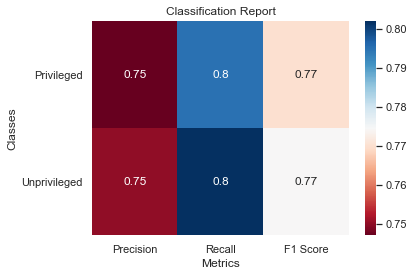

In [99]:
unb_rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            un_rw_dir, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [100]:
un_rw_dir_merg =  merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Disparate Impact Removed': dir_fair_metrics,
    'RW + DIR': unb_rw_dir_score
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Disparate Impact Removed,0.0016,0.7638,1.0116,0.0027,0.0056,0.1474
RW + DIR,0.0030,0.7653,1.0085,0.0069,0.0028,0.1469
Reweighed,0.0058,0.7633,1.0109,0.0083,0.0055,0.1473
Unbias Data,0.0160,0.7633,1.0399,0.0198,0.0194,0.1480


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


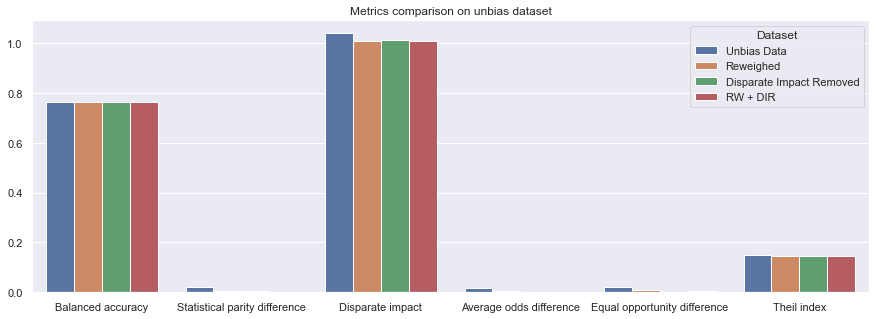

In [101]:
plot_syntesis(un_rw_dir_merg, 'Metrics comparison on unbias dataset')
plt.show()

## Test with unbalance bias data

In [102]:
unbal_dir_rw_data = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
unbal_dir_rw_data = rw.fit_transform(unbal_dir_rw_data)

In [103]:
score = compute_dataset_fairness_metrics(unbal_dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = -0.0000


Balanced accuracy: 0.7144
Statistical parity difference: 0.1108
Disparate impact: 1.2526
Average odds difference: 0.0909
Equal opportunity difference: 0.0123
Theil index: 0.1478


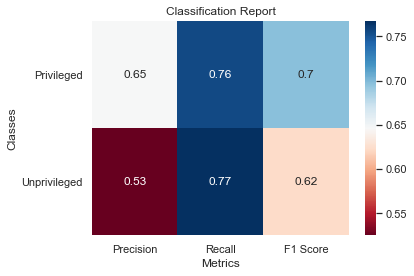

In [104]:
rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            unbal_dir_rw_data, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [105]:
unbal_rw_dir_score = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Disparate Impact Removed': dir_class_metrics,
    'RW + DIR': rw_dir_score
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias unbalanced data,-0.3549,0.7262,0.3971,-0.5165,-0.3988,0.1500
Disparate Impact Removed,0.0927,0.7057,1.0226,0.0118,0.0102,0.1502
RW + DIR,0.0909,0.7144,1.2526,0.0123,0.1108,0.1478
Reweighed,0.0107,0.7118,1.0769,-0.0895,0.0359,0.1437


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


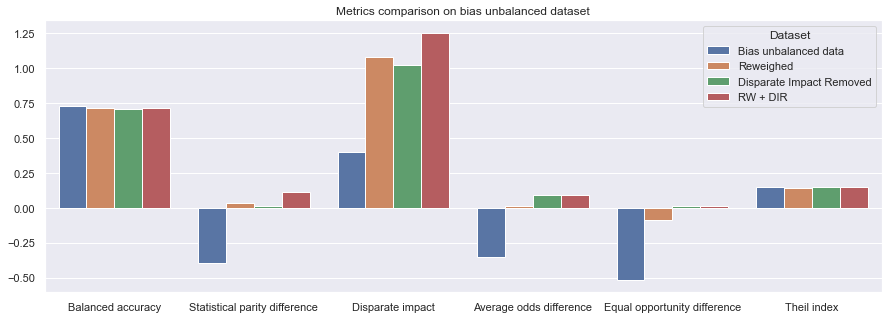

In [106]:
plot_syntesis(unbal_rw_dir_score, 'Metrics comparison on bias unbalanced dataset')
plt.show()

## Test with balanced bias data

In [107]:
dir_rw_data = dir_bal.copy()
rw = Reweighing(unprivileged_group, privileged_group)
dir_rw_data = rw.fit_transform(dir_rw_data)

In [108]:
score = compute_dataset_fairness_metrics(dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.6758
Statistical parity difference: 0.1835
Disparate impact: 1.4081
Average odds difference: 0.1836
Equal opportunity difference: 0.1940
Theil index: 0.2342


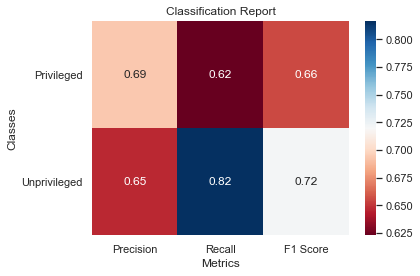

In [109]:
rw_dir_score = classify(make_pipeline(StandardScaler(),LogisticRegression(class_weight='balanced', solver='liblinear')),
                        dir_rw_data, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [110]:
rw_dir_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Disparate Impact Removed': dir_score,
    'RW + DIR': rw_dir_score
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Balanced Data,-0.8575,0.7418,0.0418,-0.8924,-0.8868,0.1901
Disparate Impact Removed,0.1840,0.6309,1.0160,0.1861,0.0074,0.2320
RW + DIR,0.1836,0.6758,1.4081,0.1940,0.1835,0.2342
Reweighed,0.0307,0.6696,1.0578,0.0251,0.0295,0.2143


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


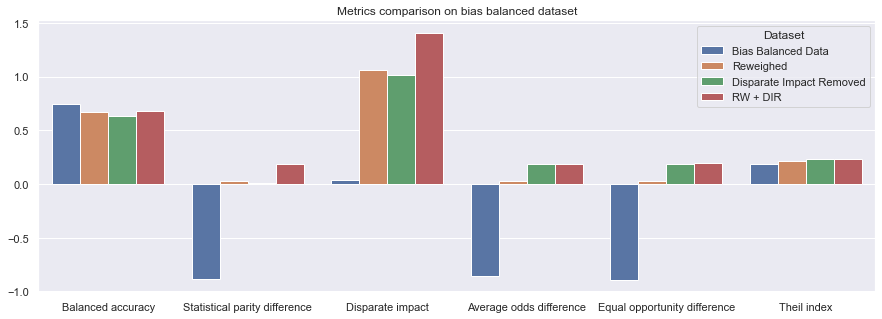

In [111]:
plot_syntesis(rw_dir_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()